In [2]:
import os
import gzip
from collections import defaultdict, Counter
import multiprocessing as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import *
import pysam
from pyBioInfo.IO.File import GffFile, BedFile
from pyBioInfo.Utils import ShiftLoader

# Make HG001 inversion reference

In [99]:
dats = pd.read_excel("data/inversions_from_cell_paper.xlsx", sheet_name=None)
dat = dats["2AGRCh38_unifiedCallset"]

f_gff = "results/inversions_cell_paper.gff"
with open(f_gff, "w+") as fw:
    for chrom, start, end, iden in dat[["seqnames", "start", "end", "inv_id"]].values:
        attributes = "ID=%s" % iden
        row = [chrom, "CellPaper", "Inversion", start + 1, end, ".", "+", ".", attributes]
        line = "\t".join(map(str, row))
        fw.write(line + "\n")    
cmd = "bgzip -f %s" % f_gff
assert os.system(cmd) == 0
cmd = "tabix -p gff -f %s.gz" % f_gff
assert os.system(cmd) == 0

In [55]:
dats = pd.read_excel("data/inversions_from_cell_paper.xlsx", sheet_name=None)
dat = dats["2AGRCh38_unifiedCallset"]
availables = ["1|0", "1|1", "0|1", "1|0_lowconf", "1|1_lowconf", "0|1_lowconf"]
dat = dat[[x in availables for x in dat["NA12878"]]]

f_gff = "results/inversions_na12878.gff"
with open(f_gff, "w+") as fw:
    for chrom, start, end, iden, gt in dat[["seqnames", "start", "end", "inv_id", "NA12878"]].values:
        attributes = "ID=%s;GenoType=%s" % (iden, gt)
        row = [chrom, "CellPaper", "Inversion", start + 1, end, ".", "+", ".", attributes]
        line = "\t".join(map(str, row))
        fw.write(line + "\n")    
cmd = "bgzip -f %s" % f_gff
assert os.system(cmd) == 0
cmd = "tabix -p gff -f %s.gz" % f_gff
assert os.system(cmd) == 0

# Make inversions gff

In [75]:
ncells = [50, 100, 150, 200, 250, 300, 350]

for ncell in ncells:

    f_bed = "../../4_NanoStrandSeq_Phasing/results/HG001_Cell_%d/inversions/inversions.bed.gz" % ncell
    f_gff = "results/inversions_%d.gff" % ncell

    with gzip.open(f_bed, "rt") as f, open(f_gff, "w+") as fw:
        iden = 0
        for line in f:
            row = line.strip("\n").split("\t")
            chrom, start, end = row[:3]
            start, end = int(start), int(end)
            c, w, r = row[3].split(";")
            c = int(c)
            w = int(w)
            confident = True
            if c + w < 20:
                confident = False
            r = w / (c + w)
            if r >= 0.9:
                t = "HOM"
            elif r > 0.6:
                t = "Uncertain"
                confident = False
            elif r >= 0.4:
                t = "HET"
            else:
                t = "Uncertain"
                confident = False

            attributes = "ID=Inv.%d;Reads=%d;Crick=%d;Watson=%d;WatsonRatio=%f;Type=%s;Confident=%s" % (iden, c + w, c, w, r, t, confident)
            row = [chrom, "NanoStrand-seq", "Inversion", start + 1, end, ".", "+", ".", attributes]
            line = "\t".join(map(str, row))
            fw.write(line + "\n")
            iden += 1
    
    cmd = "bgzip -f %s" % f_gff
    assert os.system(cmd) == 0
    cmd = "tabix -p gff -f %s.gz" % f_gff
    assert os.system(cmd) == 0

# Benchmark inversion

In [3]:
f_gff1 = "results/inversions_na12878.gff.gz"
f_gff2 = "results/inversions_350.gff.gz"

with GffFile(f_gff1) as f:
    inversions1 = [x for x in f]
print(len(inversions1))

with GffFile(f_gff2) as f:
    inversions2 = []
    for x in f:
        # if int(x.attributes["Reads"]) >= 20 and float(x.attributes["WatsonRatio"]) >= 0.25:
        if x.attributes["Confident"] == "True":
            inversions2.append(x)
print(len(inversions2))

131
339


In [102]:
ref = inversions1
que = inversions2

loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
print(len(ref), n, n / len(ref), sep="\t")

ref = inversions2
que = inversions1

loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
print(len(ref), n, n / len(ref), sep="\t")

131	70	0.5343511450381679
339	131	0.3864306784660767


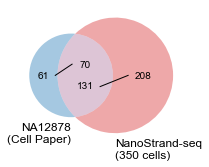

In [133]:
values = [61, 208, 100.5]
plt.figure(figsize=(3, 3))
ret = venn2(values, set_colors=["C0", "C3"], set_labels=["NA12878\n(Cell Paper)", "NanoStrand-seq\n(350 cells)"])
ret.subset_labels[2].set_text("70\n\n131")
plt.plot([0, 0.25], [-0.1, 0], lw=1, color="black")
plt.plot([-0.4, -0.25], [0, 0.1], lw=1, color="black")
plt.tight_layout()
plt.savefig("figures/benchmark_of_inversion.venn2.pdf", dpi=300)

# Make inversion gff (merged)

In [3]:
ncell = 350
f_bed = "../../A1_NanoStrandseqAssembly/results/HG001_Cell_%d/inversions/inversions.bed.gz" % ncell
f_gff = "results/inversions_%d.merged.gff" % ncell
f_bed_composite = "../../A1_NanoStrandseqAssembly/results/HG001_Cell_%s/inversions/composites/all_chroms.bed.gz" % ncell

In [36]:
def load_inversions(f_bed):
    invs = []
    with gzip.open(f_bed, "rt") as f:
        for line in f:
            row = line.strip("\n").split("\t")
            chrom, start, end = row[:3]
            start, end = int(start), int(end)
            c, w, r = row[3].split(";")
            c = int(c)
            w = int(w)
            r = w / (w + c)
            invs.append([chrom, start, end, c, w, r])
    return invs
    
def get_interval_reads(bed, chrom, start, end):
    c = 0
    w = 0
    for line in bed.fetch(chrom, start, end):
        row = line.strip("\n").split("\t")
        row[1], row[2] = int(row[1]), int(row[2])
        overlap = min(end, row[2]) - max(start, row[1])
        if overlap > 100:
            if row[5] == "+":
                c += 1
            else:
                w += 1
    return c, w

In [38]:
invs = load_inversions(f_bed)
print(len(invs))

bed = pysam.TabixFile(f_bed_composite)

i = 0
while i < len(invs) - 1:
    inv1 = invs[i]
    inv2 = invs[i + 1]
    chrom1, start1, end1, c1, w1, r1 = inv1
    chrom2, start2, end2, c2, w2, r2 = inv2
    if i % 100 == 0:
        print(i)
    if chrom1 == chrom2:
        assert start2 > end1
        c, w = get_interval_reads(bed, chrom1, end1, start2)
        if start2 - end1 < 10000 and c + w < 10:
            c3, w3 = get_interval_reads(bed, chrom1, start1, end2)
            r3 = w3 / (c3 + w3)
            # c3, w3, r3 = 0, 0, 0
            inv3 = [chrom1, start1, end2, c3,  w3, r3]
            invs[i] = inv3
            invs.pop(i + 1)
        else:
            i += 1
    else:
        i += 1
        continue
bed.close()

1603
0
100
200
300
400
500
600
700
700
700
800
900
1000
1100
1200


In [39]:
len(invs)

1234

In [40]:
with open(f_gff, "w+") as fw:
    iden = 0
    for inv in invs:
        chrom, start, end, c, w, r = inv
        confident = True
        if c + w < 20:
            confident = False
        # r = w / (c + w)
        if r >= 0.9:
            t = "HOM"
        elif r > 0.6:
            t = "Uncertain"
            confident = False
        elif r >= 0.4:
            t = "HET"
        else:
            t = "Uncertain"
            confident = False

        attributes = "ID=Inv.%d;Reads=%d;Crick=%d;Watson=%d;WatsonRatio=%f;Type=%s;Confident=%s" % (iden, c + w, c, w, r, t, confident)
        row = [chrom, "NanoStrand-seq", "Inversion", start + 1, end, ".", "+", ".", attributes]
        line = "\t".join(map(str, row))
        fw.write(line + "\n")
        iden += 1

cmd = "bgzip -f %s" % f_gff
assert os.system(cmd) == 0
cmd = "tabix -p gff -f %s.gz" % f_gff
assert os.system(cmd) == 0

## benchmark

In [74]:
f_gff1 = "results/inversions_na12878.gff.gz"
f_gff2 = "results/inversions_350.merged.gff.gz"

with GffFile(f_gff1) as f:
    inversions1 = [x for x in f]
print(len(inversions1))

with GffFile(f_gff2) as f:
    inversions2 = []
    for x in f:
        # if int(x.attributes["Reads"]) >= 20 and float(x.attributes["WatsonRatio"]) >= 0.25:
        if x.attributes["Confident"] == "True" and int(x.attributes["Reads"]) >= 40:
            inversions2.append(x)
#         if x.attributes["Confident"] == "False" and int(x.attributes["Reads"]) >= 40:
#             print(x.format())
print(len(inversions2))

131
195


In [78]:
bed = pysam.TabixFile(f_bed_composite)
span = 500

tmp = []
vs = []
for inv in inversions2:
    c1, w1 = get_interval_reads(bed, inv.chrom, inv.start - span, inv.start)
    c2, w2 = get_interval_reads(bed, inv.chrom, inv.end, inv.end + span)
    n1, n2 = c1 + w1, c2 + w2
    density = int(inv.attributes["Reads"]) * 1000 / len(inv)
    vs.append(density)
    if density < 8 and n1 >= 1 and n2 >= 1:
        tmp.append(inv)
bed.close()
print(len(tmp))
# inversions2 = tmp

31


In [62]:
# import pyBigWig

# def worker(f_bw, chrom, step, min_coverage, max_coverage):
#     regions = []
    
#     with pyBigWig.open(f_bw) as f:
#         length = f.chroms()[chrom]
        
#         step1 = step * 1000
#         for start1 in range(0, length, step1):
#             end1 = min(start1 + step1, length)
#             covs = f.values(chrom, start1, end1)
            
#             for start2 in range(start1, end1, step):
#                 end2 = min(start2 + step, end1)
#                 vs = np.nan_to_num(covs[start2 - start1:end2 - start1])
#                 mean = np.mean(vs)
#                 if mean < min_coverage or mean > max_coverage:
#                     if len(regions) == 0:
#                         regions.append([chrom, start2, end2])
#                     else:
#                         if start2 <= regions[-1][2]:
#                             regions[-1][2] = end2
#                         else:
#                             regions.append([chrom, start2, end2])
                            
#     return regions


# def scan_extreme_coverage_regions(f_bw, f_bed, threads=1, min_coverage=15, max_coverage=80):
#     array = []
#     pool = mp.Pool(threads)
#     with pyBigWig.open(f_bw) as f:
#         for chrom in f.chroms():
#             args = (f_bw, chrom, 100, min_coverage, max_coverage)
#             array.append(pool.apply_async(worker, args))
#     pool.close()
#     pool.join()

#     regions = []
#     for r in array:
#         regions.extend(r.get())
#     regions.sort()
    
#     with open(f_bed, "w+") as fw:
#         for r in regions:
#             fw.write("\t".join(map(str, r)) + "\n")
            
# f_bw = "../../6_nss-pseudobulk-analysis/results/bw/PacBio.full.bw"
# f_bed = "results/PacBio.full.coverage_lt_0_gt_80.bed"
# scan_extreme_coverage_regions(f_bw, f_bed, 24, 0, 80)

In [63]:
# SV blacklist

def load_bed(path):  
    with BedFile(path) as f:
        regions = [x for x in f]
        regions.sort()
        return regions

# regions1 = load_bed("../2_DownsampleBenchmark/data/PacBio.full.coverage_lt_15_gt_80.bed")
# regions2 = load_bed("../2_DownsampleBenchmark/data/Ultralong.full.coverage_lt_15_gt_80.bed")
# regions = regions1 + regions2
# regions.sort()

regions = load_bed("results/PacBio.full.coverage_lt_0_gt_80.bed")

tmp = []
loader = ShiftLoader(regions)
for inv in inversions2:
    hit = False
    for r in loader.fetch(obj=inv):
        s = max(inv.start, r.start)
        e = min(inv.end, r.end)
        if e - s >= 100:
            hit = True
    if not hit:
        tmp.append(inv)
print(len(inversions2), len(tmp))

inversions2 = tmp

124 124


In [64]:
ref_no_hit = 0
ref_hit = 0
que_no_hit = 0
que_hit = 0

ref = inversions1
que = inversions2

loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
print(len(ref), n, n / len(ref), len(ref) - n, sep="\t")
ref_hit = n
ref_no_hit = len(ref) - ref_hit

ref = inversions2
que = inversions1

invs_nss_only = []

loader = ShiftLoader(que)
n = 0
for inv1 in ref:
    hit = False
    for inv2 in loader.fetch(obj=inv1):
        hit = True
    if hit:
        n += 1
    else:
        invs_nss_only.append(inv1)
print(len(ref), n, n / len(ref), len(ref) - n, sep="\t")
que_hit = n
que_no_hit = len(ref) - que_hit

print(ref_hit, ref_no_hit, que_hit, que_no_hit)

131	56	0.42748091603053434	75
124	67	0.5403225806451613	57
56 75 67 57


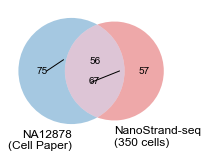

In [65]:
values = [ref_no_hit, que_no_hit, (ref_hit + que_hit) / 2]
plt.figure(figsize=(3, 3))
ret = venn2(values, set_colors=["C0", "C3"], set_labels=["NA12878\n(Cell Paper)", "NanoStrand-seq\n(350 cells)"])
ret.subset_labels[2].set_text("%d\n\n%d" % (ref_hit, que_hit))
plt.plot([0, 0.25], [-0.1, 0], lw=1, color="black")
plt.plot([-0.4, -0.25], [0, 0.1], lw=1, color="black")
plt.tight_layout()
plt.show()
# plt.savefig("figures/benchmark_of_inversion.venn2.pdf", dpi=300)